<a href="https://colab.research.google.com/github/greyxray/mbd_research_notebooks/blob/main/Recipes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from collections import defaultdict
import re
import string

import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

## Goal
Our goal in this session is to use Pytorch and get familiar with it's api by building a HelloFresh recipe title generator.

## How
Since this is NLP, we will build it by first looking at a bigram model. Then we will look at a neural net. And finally look at sequence models.

We will read the recipe titles and do some basic preprocessing to clean out the junk:

## If you need the dataset file, reach out to me, I don't post it here cuz I might get sued for GDPR or something :)

In [ ]:
recipes = pd.read_parquet("recipes.parquet").query("country.isin(['AU', 'US', 'GB', 'CA', 'NZ', 'CK'])")
recipes["title"] = recipes["title"].fillna("") + " " + recipes["recipe_headline"].fillna("")
recipes["title"] = recipes["title"].apply(lambda x: x.replace("None", ""))
recipes["title"] = recipes["title"].apply(lambda x: x.replace("\u200c", ""))
recipes["title"] = recipes["title"].apply(lambda x: x.replace("-wk", ""))
recipes["title"] = recipes["title"].apply(lambda x: x.replace("“", ""))
recipes["title"] = recipes["title"].apply(lambda x: x.replace("‘", ""))
recipes["title"] = recipes["title"].apply(lambda x: x.replace("’", ""))
recipes["title"] = recipes["title"].apply(lambda x: re.sub(r"\([^)]*\)", "", x))
recipes["title"] = recipes["title"].apply(lambda x: ' '.join(s for s in x.split() if not any(c.isdigit() for c in s)))
recipes["title"] = recipes["title"].apply(lambda x: x.replace("-", " ").replace(",", ""))
recipes["title"] = recipes["title"].apply(lambda x: x.replace("&", "and"))
recipe_titles = recipes["title"].tolist()
print(f"Total number of recipe titles: {len(recipe_titles)}")
recipe_titles[:5]

Total number of recipe titles: 95473


['Shroom Burger with Caramelised Onion and Fried Egg',
 'Haloumi Burger with Hummus and Red Capsicum Relish',
 'Carne Asada Tacos with Black Beans',
 'Pan Seared Sea Bass with New Potatoes and Cucumber Dill Relish',
 'Grain Mustard Potato Salad with Grilled Chicken']

That looks...reasonable, and deceptively clean. Let's first find how many unique characters there are in all the titles in our dataset:

In [ ]:
unique_chars = set()
for title in recipe_titles:
    for char in title.lower():
        unique_chars.add(char)
print(f"{len(unique_chars)=}")

len(unique_chars)=75


Well that ain't good, there should be 26, let's see what these extras are?

In [ ]:
print(unique_chars)

{'̧', 'y', '–', '=', 'z', 'œ', 'ü', '”', 'í', 'x', 'i', 'ê', 'r', 'h', 'ç', '.', 's', 'á', 'f', 'ù', 'ñ', '?', 'é', 'm', '‑', '̃', 'u', ':', '̂', ']', 'q', 'ó', 'ⓡ', '￼', 'à', ';', '*', '́', ' ', '️', 'd', 'e', '|', '—', 'b', 'a', 'û', 'o', 'n', 'è', '™', 'ʼ', 't', 'k', '̀', '®', '+', '\ufeff', 'l', 'j', "'", 'c', 'w', '!', 'ï', '"', 'â', 'p', 'v', 'g', 'î', '[', 'ì', 'ô', 'ϋ'}


This looks like a pain to clean up. Let's just build an alphabet containing the 26 english characters. We will then add two special charactors in our alphabet or vocabulary as it is called in literature. These will the special start \<S> and end \<E> token. These are used to indicate when generation of a sequence starts or ends. Our start and end tokens can be the same, we'll use "." as the start and end token. We also need the space character " " in our vocabulary. So that makes a total of 28.

Then we will build a bigram model. Basically a model that creates a NxN matrix, where N is the number of tokens in our vocabulory (in this case 28). The rows are all the i-th words, and the columns are the i+1-th words in the second (1st word, second word if you wanna think of it simply). We basically count how many times this bigram occurs:

In [ ]:
vocab = set(string.ascii_lowercase)
vocab.add(" ")
lookup_table = {char: i+1 for i, char in enumerate(sorted(list(vocab)))}
lookup_table["."] = 0
reverse_lookup_table = {i: char for char, i in lookup_table.items()}

# N is the bigram counts matrix
N = torch.zeros(len(lookup_table), len(lookup_table), dtype=torch.int32)
recipe_titles_used = 0
for title in tqdm(recipe_titles):
    title = title.lower()
    title_chars = set(title)
    # if title contains characters out of the vocab, or is empty, skip it
    if title_chars - vocab or not title_chars:
        continue
    title = ["."] + list(title) + ["."]
    for char1, char2 in zip(title, title[1:]):
        idx1 = lookup_table[char1]
        idx2 = lookup_table[char2]
        N[idx1, idx2] += 1
    recipe_titles_used += 1
print(f"{recipe_titles_used=}")

  0%|          | 0/95473 [00:00<?, ?it/s]

recipe_titles_used=78838


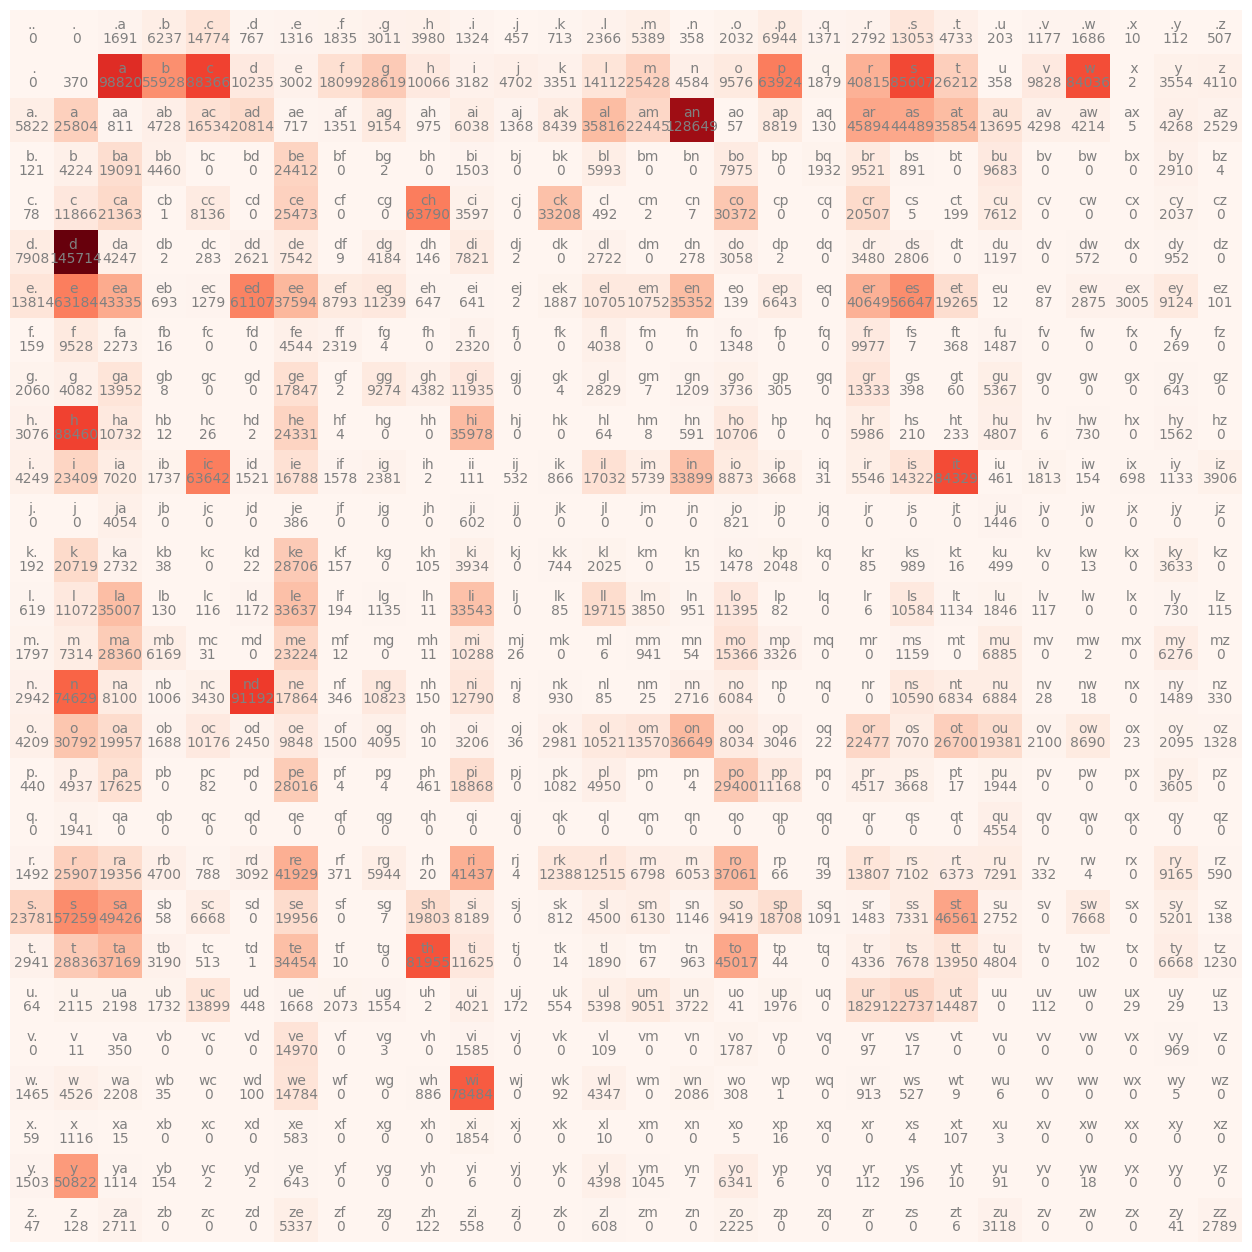

In [ ]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Reds')
for i in range(28):
    for j in range(28):
        chstr = reverse_lookup_table[i] + reverse_lookup_table[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

That's mostly it for the bigram model. Since we have the counts matrix N, we can turn it into probabilities by normalizing it, from which we get P. Each row gives the probability of the next character, given the current row's character.

We can now sample from this model, to get new recipes:

In [ ]:
SN = N + 1 # Smoothing (if all elements in a row are 0, sum would be 0, then we would end up dividing by 0)
P = SN / SN.sum(dim=1, keepdim=True)

NameError: ignored

In [ ]:
g = torch.Generator().manual_seed(2147483497)
for i in range(10):
    idx = lookup_table["."]
    title = []
    while True:
        p = P[idx]
        idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if idx == lookup_table["."]:
            break
        title.append(reverse_lookup_table[idx])
    print("".join(title))

witaethity antand wierickey gneshiay th d wiadlarinicoourr s bo pineegekind s
by cky bo mour r
chi cesad mbemorgiped vend s swer burilote
ge ttatsach coatcond led ffee seeritour and bey aroorethegumithith a ggrex anthi
si f veshe vepi
osyous
wi
che wi crolloseacowind cke chito ked w we rrear g fest belomos
vileped d poe repon swicr ls rond
llareefrr acharemad bee buri poto satheres mandlash wio thesaienc witt chey be s it pind wiitagin sotrinitadicoarmegremband angrieed rky ch ppoco po my ak sth tout wi mon trithrouchur wied ck ch praregasaretuseens aranumic wis co s anifrimutitoartowiaronsay s ndasas


That's not really great. But it is expected. Our model only knows what the previous character was, that's not a lot of information to go by for building recipe titles.

Next, as an exercise, let's create the same bigram model, but with a supervised learning approach.

Also it would be a good idea to define a loss function at this point.
We model the problem as picking the next most likely/probable character given the current character:

prob_of_title = p(C_i | C_i-1) * p(C_i-1 | C_i-2) * ... * p(C_1 | C_0)

Since probabilities are between 0 and 1, multiplying a long chain of these probabilities leads to very small numbers and sometimes numerical instability/underflow. To avoid this, we work with something equivalent, called log probabilities, which is just a log of the above equation:

log(prob_of_title) = log(p(C_i | C_i-1)) + log(p(C_i-1 | C_i-2)) + ... + log(p(C_1 | C_0))

Since now we are dealing with sums, log probs have nicer mathematical properties, especially for gradient based optimization, which is what we will be doing.

Let's calculate what the average log probability across all the titles and build our training dataset:

In [ ]:
nll, n = 0, 0
xs, ys = [], []
for title in tqdm(recipe_titles):
    title = title.lower()
    title_chars = set(title)
    # if title contains characters out of the vocab, or is empty, skip it
    if title_chars - vocab or not title_chars:
        continue
    title = ["."] + list(title) + ["."]
    for char1, char2 in zip(title, title[1:]):
        idx1 = lookup_table[char1]
        idx2 = lookup_table[char2]
        xs.append(idx1)
        ys.append(idx2)
        nll += P[idx1, idx2].log()
        n += 1
print(f"Avg NLL = {-nll / n}")

  0%|          | 0/95473 [00:00<?, ?it/s]

Avg NLL = 2.2679646015167236


In [ ]:
xs = torch.tensor(xs).long()
ys = torch.tensor(ys).long()

In [ ]:
device = torch.device("cpu") # Can be "mps" for M1 or "cuda" for GPU
W = torch.zeros(len(lookup_table), len(lookup_table))
W = W.to(device)
W.requires_grad = True
xenc = torch.nn.functional.one_hot(xs, num_classes=len(lookup_table)).float().to(device)

In [ ]:
opt = torch.optim.AdamW([W], lr=0.1, weight_decay=1e-4)
for step in tqdm(range(400)):
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdims=True)
    nll = -probs[torch.arange(len(xs)), ys].log().mean()
    opt.zero_grad()
    nll.backward()
    opt.step()
    if step % 10 == 0:
        print(nll.item())
        torch.save(W, "weight_matrix.pt")

In [ ]:
g = torch.Generator().manual_seed(2147483497)
W = torch.load("weight_matrix.pt").to("cpu")
xenc = xenc.to("cpu")
for i in range(10):
    idx = lookup_table["."]
    dish = []
    with torch.no_grad():
        while True:
            xenc = torch.nn.functional.one_hot(xs[idx], num_classes=len(lookup_table)).float()
            logits = (xenc @ W).exp()
            p = logits / logits.sum()
            idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
            if idx == lookup_table["."]:
                break
            dish.append(reverse_lookup_table[idx])

    print("".join(dish))

wttcaugrwya eya mrwmdrmcoozeeotshsaulrkebauea tcrlksctniiraieaiaeeeolieeonilo 
wbeiuk p eotn
q
ckra  tmaiigeeotnilgeepooscsaiyai  tniirtma a tuaqoea  aiepeonieeea aa eaiiiomtsrma eeea ya popieuikgueionione 
hrwaua arpo
sk a tniimaieii
otyuso wa
cni ya aotnisoniaiylkma mk  aisobiieiy tc otmbnee a tsa cniiot wphloea a loc ocrphcsuiao eueioni crbocnisra  aaiegea  eea tni hsotctnikniepaa eeuaikaotnephrtmbeie vsotcdniya eaia p likmcwa pa nieosotnirsc tmvkrrmotllea aeactshmlgeiktmcgeeuniraeo eye
caiuidtsrw
vt eoneprgumwotdkwe wieea ocgeeitdrcneocshtummlltk paaueib tmrceo p  lofweeurrwocrwotneotnieyaieeeotmsairw aonieu mwao


## Neural Probabilistic Language Model
Next, we build up on our gradient descent based approach, since it is more flexible.

We will implement: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf by Bengio et al (2003) in PyTorch, with some simplifications (mainly we wont be propagating the word embeddings to the final layer, to reduce computation)


In [ ]:
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for title in tqdm(recipe_titles):
    title = title.lower()
    title_chars = set(title)
    # if title contains characters out of the vocab, or is empty, skip it
    if title_chars - vocab or not title_chars:
        continue
    context = [0] * block_size # Start with 3 start tokens
    for char in title + '.':
        idx = lookup_table[char]
        X.append(context)
        Y.append(idx)
        # print([reverse_lookup_table[c] for c in context], char)
        context = context[1:] + [idx]

X = torch.tensor(X)
Y = torch.tensor(Y)

  0%|          | 0/95473 [00:00<?, ?it/s]

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((28, 2), generator=g) # Embedding dimension of 2 is very low, try increasing it
W1 = torch.randn((6, 100), generator=g) # since we will concat 3 words, each with dimensionality 2, this layer has shape 3x2 => 6
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 28), generator=g) # size of the output is 28 for each character
b2 = torch.randn(28, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [ ]:
losses = []
for i in tqdm(range(200000)):
    idxs = torch.randint(0, X.shape[0], (128,))
    emb = C[X[idxs]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = torch.nn.functional.cross_entropy(logits, Y[idxs])

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    losses.append(loss.log10().item())

  0%|          | 0/200000 [00:00<?, ?it/s]

In [ ]:
plt.plot(losses)

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = torch.nn.functional.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        out.append(idx)
        if idx == 0:
            break

    print(''.join(reverse_lookup_table[i] for i in out))

bary butte.
smoto pasted veggie tomato chirmoto and cremarameliztoket fotto sty chicken jan chay with a fetta couscouicket bash saucede saled plla slaw and messes with chice.
creany gurame sallot and buan beln green steak lime salad.
cornutballe and tomatoes.
tarey with tomati rice and gretef wedgesscarrotsegvem.
chicken touf onion greeme salad.
vegducken mishroom green tored a mrupotato ricedlizore rice chicken ind buans and bean and spicul with sal chell and lemonatomatoes corima.
on.
crerlock beef tir frae pork and carraty rozziss and cucan slaw burn green and mumro qnion rivo chops and slafbattaho beaph chipotfescan chellu with corn tand pata with a gart geat bear.
cruadrared oou with torickebarrauscolzy iucken with rice and gotti with butti.
tomato chicken with bekey pine with onitter chillato with carach parg with moconuon ands.
sii with egettacos with chickepo with rogotable fressepe rice and salsame piluanut povo pllared poppeto plazed sese with cap a cheen beef with sty plu to

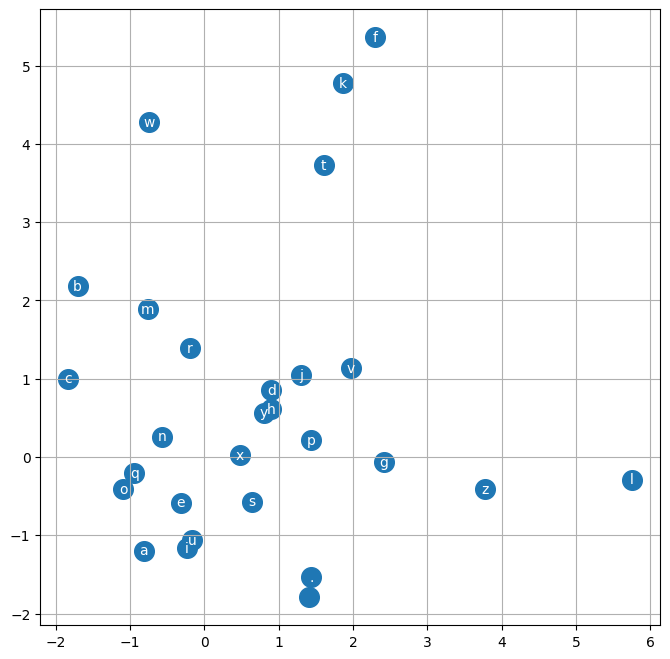

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), reverse_lookup_table[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
class RecipeTitle(torch.utils.data.Dataset):

    def __init__(self, recipe_titles):
        self.vocab = set(string.ascii_lowercase)
        self.vocab.add("&")
        self.vocab.add(" ")
        self.lookup_table = {char: i+2 for i, char in enumerate(sorted(list(self.vocab)))}
        self.lookup_table["."] = 0
        self.lookup_table["/"] = 1
        self.reverse_lookup_table = {i: char for char, i in self.lookup_table.items()}
        self.recipe_titles = []
        self.max_length = 0
        for title in tqdm(recipe_titles):
            title = title.lower()
            title_chars = set(title)
            # if title contains characters out of the vocab, or is empty, skip it
            if title_chars - self.vocab or not title_chars:
                continue
            self.recipe_titles.append(title)
            if len(title) > self.max_length:
                self.max_length = len(title)

    def __len__(self):
        return len(self.recipe_titles)

    def __getitem__(self, idx):
        title = "." + self.recipe_titles[idx] + "/"
        x, y = torch.zeros(len(title) - 1, dtype=torch.long), torch.zeros(len(title) - 1, dtype=torch.long)
        for i, (char1, char2) in enumerate(zip(title, title[1:])):
            idx1 = self.lookup_table[char1]
            idx2 = self.lookup_table[char2]
            x[i], y[i] = idx1, idx2
        return x, y

dataset = RecipeTitle(recipe_titles)

  0%|          | 0/95473 [00:00<?, ?it/s]

Next we'll use a better model, which will predict the next character, given all previous characters so far:

P(C_t+1 | C_t, C_t-1, .... C_0)

RNNs are a great model for this, the graphic below summarizes how an RNN works (Taken from the excellent CS231n course notes: https://cs231n.github.io/rnn):

I'll skip the implementation of an RNN for this knowledge sharing session, as they suffer from the gradient vanishing problem for long sequences. I encourage you try to implement one in PyTorch and see how it performs on this dataset.

We go directly to using an LSTM (A great resource: https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
Instead of implementing the LSTM ourselves, we will use the native PyTorch implementation to see how PyTorch helps with removing boilerplate by providing these classes. You are welcome to try and implement one by yourself as an exercise.

In [ ]:
class RNN(torch.nn.Module):

    def __init__(self, vocab_size, embed_dim, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embed = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        self.rnn = torch.nn.LSTMCell(input_size=embed_dim, hidden_size=hidden_size)
        self.output = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x, h, c):
        x = self.embed(x)
        h, c = self.rnn(x, (h, c))
        o = self.output(h)
        return o, h, c

    def init_hidden(self):
        hidden = torch.zeros(1, self.hidden_size)
        cell = torch.zeros(1, self.hidden_size)
        return hidden, cell
device = torch.device("cpu")
model = RNN(len(dataset.vocab) + 2, 64, 64, len(dataset.vocab) + 2)
model.to(device)

RNN(
  (embed): Embedding(30, 64)
  (rnn): LSTMCell(64, 64)
  (output): Linear(in_features=64, out_features=30, bias=True)
)

In [ ]:
opt = torch.optim.AdamW(model.parameters(), lr=1e-2)
losses = []
for step, (x, y) in tqdm(enumerate(iter(dataset))):
    x, y = x.to(device), y.to(device)
    h, c = model.init_hidden()
    h, c = h.to(device), c.to(device)
    loss = 0
    for i in range(len(x)):
        o, h, c = model(x[i].unsqueeze(0), h, c)
        loss += torch.nn.functional.cross_entropy(o, y[i].view(1))
    loss = loss / len(x)
    loss.backward()
    if step % 128 == 0:
        opt.step()
        opt.zero_grad()
    if step % 150 == 0:
        losses.append(loss.item())
plt.plot(losses)

In [ ]:
model.load_state_dict(torch.load("rnn.pt"))
model.eval()
for i in range(20):
    output = torch.tensor([0])
    h, c = model.init_hidden()
    title = []
    while True:
        with torch.no_grad():
            output, h, c = model(output, h, c)
            probs = output.softmax(dim=1)
            idx = torch.multinomial(probs, num_samples=1).item()
            if idx == 1:
                break
            title.append(dataset.reverse_lookup_table[idx])
            output = torch.tensor([idx])
    print("".join(title))

honey mayon and garlicky paspared broccoli
lamb and roveaton garlic grilled beans and brganese tabbow pasta with roasted chutney ginger dressey and bbq cori
sweet and bbq burrita cheese and bbq spiced pesto and cheesy pork ravion pan
port chickpea baked herbed pragu with pan mayo
shrim fried ruffuled with roasted oldini bowls with fresh shrimp chuked beans pericot pasta salad
steak meatballs with avocod ned chicken with melty bbq sauce with chipory chicken tacoss with linguinelin with pancandon cheese
beef rice
pork plattobo fajita and zucchini chop parmesan and redd
chermoula with singaefa chicken with spinach and crispy mushroom pasto
chicken and scallions pineapple pork pyok and potatoes
chicken peang burger with roasted vegge
moroccan bolognese with honey and bacon pear sweet potato glat mango spice curry with mashed potatoes and rocket and coconut salad with fried chilli and baby lentil rice
korean sauce
crispy pumpkin ricoutbons
mexican beefh robun parsley qurocchuma with canian 